In [538]:
import pandas as pd
import numpy as np
import re
import missingno
import matplotlib.pyplot as plt

# Load Data
There are two files to work with. The first file contains a list of alcohol license violations. I use this as intended. The second is a list of alcohol licenses. I use this to create a new csv file, which contains information about in which city each zip code is located.

In [539]:
df = pd.read_csv('Alcoholic_Beverage_License_Violations-API.csv')


First, the head of the violation dataframe.

In [540]:
df.head()

,FacilityName,FacilityAddress,Violation,Disposition,DispositionDate
0,FLOWER CHILD,"10072 DARNESTOWN RD. , ROCKVILLE, MD 20860",SALE TO MINOR,SETTLED;$1000+ALERT,03/05/2019
1,BUFFALO WILD WINGS,"33 MARYLAND AVE. , ROCKVILLE, MD 20850",ALCOHOL AWARENESS CERTIFIED PERSON NOT ON PREM...,SETTLED;$100+ALERT,08/21/2019
2,"TACOS, TORTAS & TEQUILA","8407 RAMSEY AVE. , SILVER SPRING, MD 20910",LICENSE NOT PROPERLY DISPLAYED,SETTLED; 100+ ALERT,04/03/2019
3,THE SPOT,"255 NORTH WASHINGTON ST. , ROCKVILLE, MD 20850",EMPLOYEE RECORDS NOT AVAILABLE WHEN REQUESTED,SETTLED;$500+ALERT,08/06/2019
4,THE SPOT,"255 NORTH WASHINGTON ST. , ROCKVILLE, MD 20850",ALCOHOL AWARENESS CERTIFIED PERSON NOT ON PREM...,SETTLED;$100+ALERT,08/06/2019


# Data Cleaning and Feature Engineering

## Cleaning Violations
Some of the violations contain statutory indices in their descriptions and some do not. This means that the number of categories in the Violation features exceeds the number of actual categorizations. To fix tthis, I remove the statutory indices. I also change the case of the text, for readability.

Below are the unique types of violations present in the data.

In [541]:
df['Violation'].unique()

array(['SALE TO MINOR',
       'ALCOHOL AWARENESS CERTIFIED PERSON NOT ON PREMISES',
       'LICENSE NOT PROPERLY DISPLAYED',
       'EMPLOYEE RECORDS NOT AVAILABLE WHEN REQUESTED',
       '5.7 DISPLAY OF LICENSE',
       'REFILLING EMPTY/PARTIALLY EMPTY ALCOHOLIC BOTTLES', 'STORAGE',
       'SELLING/SERVING ALCOHOL AFTER PERMITTED HOURS',
       '6.1 SALES OR SERVICE TO MINORS/CONSUMPTION OR POSSESSION OF MINORS',
       '5.4 ALCOHOL AWARENESS CERTIFICATION', 'RECORDS INVOICE VIOLATION',
       'KEG REGISTRATION VIOLATION', 'CLASS LICENSE VIOLATION',
       'ACTS CONTRARY TO LAW', '6.9 STORAGE',
       'APPLICATION - FAILURE TO UPDATE', 'DISORDERLY HOUSE',
       '6.4 CONSUMPTION, POSSESSION, OR SALE DURING PROHIBITED HOURS',
       '6.0 ACTS CONTRARY TO LAW', '5.10 DISPENSING OF LIQUOR',
       'GAMBLING ON PREMISES', 'AGE OF EMPLOYEE VIOLATION',
       'NO VIOLATION',
       'DISPENSING LIQUOR BY BOTTLE FOR CONSUMPTION ONSITE',
       'NO ENTERPRISE LICENSE', 'LICENSE COMPLIANCE CHE

Above, for example, we see both 'ACTS CONTRARY TO LAW' and '6.0 ACTS CONTRARY TO LAW.' These duplicates can be removed using string operations. In fact, I remove the statutory numbering entirely, since it is distracting.

In [542]:
def remove_dup_violation(violation_string):
    split_violation = violation_string.split(' ')
    
    # Clean up the text
    split_violation = [tok.title().strip() for tok in split_violation]
    
    # Check if statutory numbering is present and remove if so
    if split_violation[0].isalpha():
        return ' '.join(split_violation)
    else:
        return ' '.join(split_violation[1:])

In [543]:
df['Violation'] = df['Violation'].apply(remove_dup_violation)

In [544]:
df['Violation'].unique()

array(['Sale To Minor',
       'Alcohol Awareness Certified Person Not On Premises',
       'License Not Properly Displayed',
       'Employee Records Not Available When Requested',
       'Display Of License',
       'Refilling Empty/Partially Empty Alcoholic Bottles', 'Storage',
       'Alcohol After Permitted Hours',
       'Sales Or Service To Minors/Consumption Or Possession Of Minors',
       'Alcohol Awareness Certification', 'Records Invoice Violation',
       'Keg Registration Violation', 'Class License Violation',
       'Acts Contrary To Law', 'Application - Failure To Update',
       'Disorderly House',
       'Consumption, Possession, Or Sale During Prohibited Hours',
       'Dispensing Of Liquor', 'Gambling On Premises',
       'Age Of Employee Violation', 'No Violation',
       'Dispensing Liquor By Bottle For Consumption Onsite',
       'No Enterprise License', 'License Compliance Check',
       'Of The Neighborhood', 'Responsibility', 'Prohibited Hours',
       'Change

## Processing Dispositions

The goal here is to find classes of dispositions as well as the amounts of any fines assessed. The issue is that there seems to be no standarad format for describing a disposition.

First, I remove missing values. Second, I fix some typos in the feature. Third, I remove commas. Because some disposition descriptions have commas in them, and some do not. This makes it harder to process text.

Below, we can see values with no disposition information.

In [545]:
df[df['Disposition'].isna()]

,FacilityName,FacilityAddress,Violation,Disposition,DispositionDate
94,GAITHERSBURG SUPERMARKET,"220 EAST DIAMOND AVE , GAITHERSBURG , MARYLAND...",Alcohol Awareness Certification,NaN,NaN
141,BALAGGER RESTUARANT,"8081 GEORGIA AVE , SILVER SPRING , MARYLAND - ...",No Violation,NaN,NaN
181,DESSIE ETHIOPIAN RESTAURANT & MARKET,"2655 UNIVERSITY BLVD , WHEATON , MARYLAND - 20902",Changes In Licensing Information,NaN,NaN
182,DESSIE ETHIOPIAN RESTAURANT & MARKET,"2655 UNIVERSITY BLVD , WHEATON , MARYLAND - 20902",Disorderly House,NaN,NaN
183,DESSIE ETHIOPIAN RESTAURANT & MARKET,"2655 UNIVERSITY BLVD , WHEATON , MARYLAND - 20902",Open Containers,NaN,NaN
184,DESSIE ETHIOPIAN RESTAURANT & MARKET,"2655 UNIVERSITY BLVD , WHEATON , MARYLAND - 20902",Licensee'S Responsibility,NaN,NaN
185,DESSIE ETHIOPIAN RESTAURANT & MARKET,"2655 UNIVERSITY BLVD , WHEATON , MARYLAND - 20902",Sales Or Service To Intoxicated Persons/Consum...,NaN,NaN
186,DESSIE ETHIOPIAN RESTAURANT & MARKET,"2655 UNIVERSITY BLVD , WHEATON , MARYLAND - 20902","Consumption, Possession, Or Sale During Prohib...",NaN,NaN
187,DESSIE ETHIOPIAN RESTAURANT & MARKET,"2655 UNIVERSITY BLVD , WHEATON , MARYLAND - 20902",Compliance With Laws And Regulations,NaN,NaN
188,DESSIE ETHIOPIAN RESTAURANT & MARKET,"2655 UNIVERSITY BLVD , WHEATON , MARYLAND - 20902",False Statement,NaN,NaN


We can note a couple of things here. First, a single restaurant, Dessie Ethiopian, is overrepresented. Second, where there is no disposition information, there is also no disposition date. Since there is no clear good way to impute these missing values, and the disposition feature is crucial to further analysis, I drop these samples.

In [546]:
df = df[df['Disposition'].notna()]

Next, I remove commas.

In [547]:
def settled_typos(disposition):
    if isinstance(disposition, str):
        disposition = disposition.replace('SETTELD', 'SETTLED')\
            .replace('SETTED', 'SETTLED')\
                .replace('SETTELD', 'SETTLED')\
                    .replace('SETTLLED', 'SETTLED')\
                        .replace('SETTLLED', 'SETTLED')\
                            .replace('SEETLED', 'SETTLED')
    return disposition



df['Disposition'] = df['Disposition'].map(settled_typos).str.replace(',', '')

I categorize unique values to see if there are any reoccuring patterns. By far the most common terms in the dispositions are some variant of settled, suspension, or hearing.

In [548]:
disp_vals = df.Disposition.unique()
disp_dict = {}

for cat in disp_vals:
    if isinstance(cat, str) and 'SETTLED' in cat:
        if 'SETTLED' in disp_dict: # some typos in report
            disp_dict['SETTLED'].append(cat)
        else:
            disp_dict['SETTLED'] = [cat]
    elif isinstance(cat, str) and 'SUSPEN' in cat:
        if 'SUSPENSION' in disp_dict: # some typos in report
            disp_dict['SUSPENSION'].append(cat)
        else:
            disp_dict['SUSPENSION'] = [cat]
    elif isinstance(cat, str) and 'HEAR' in cat:
        if 'HEARING' in disp_dict: # some typos in report
            disp_dict['HEARING'].append(cat)
        else:
            disp_dict['HEARING'] = [cat]
    else:
        if 'remainder' in disp_dict:
            disp_dict['remainder'].append(cat)
        else:
            disp_dict['remainder'] = [cat]
            

Below are ten example dispositions that I put in each category. I show only ten to give a general idea of the sort of dispositions that show up in each grouping. Remember, the goal with this dictionary is just to group strings together to help formatting patterns pop out.

In [549]:
disp_dict['SETTLED'][:10]

['SETTLED;$1000+ALERT',
 'SETTLED;$100+ALERT',
 'SETTLED; 100+ ALERT',
 'SETTLED;$500+ALERT',
 'SETTLED $100 +ALERT',
 'SETTLED; $500+ALERT',
 'SETTLED;$800+ALERT',
 'SETTLED;$2900+ALERT',
 'SETTLED;$400+ALERT',
 'SETTLED; $500 + ALERT']

In [550]:
disp_dict['SUSPENSION'][:10]

['TWO WEEK SUSPENSION FROM MAY 13-26 2019',
 'TWO WEEK SUSPENSION; SEPTEMBER 16 2019- SEPTEMBER 30 2019 + ALERT',
 'SIX WEEK SUSPENSION FROM SEPTEMBER 16-OCTOBER 272019',
 '2 WEEK SUSPENSION + ALERT (OCTOBER 9-OCTOBER 22 2019)',
 '2 WEEK SUSPENSION STARTING FROM JANUARY 6-JANUARY 192020',
 '10 DAY SUSPENSION; NOVEMBER 20-NOVEMBER 29 2019',
 '2 WEEK SUSPENSION FROM JANUARY 6-JANUARY 19 2020',
 '2 DAY SUSPENSION FROM DECEMBER 23-24 2019',
 '2 WEEK SUSPENSION STARTING FROM JANUARY 20- FEBRUARY 92020',
 'HEARING; 10 DAY SUSPENSION']

In [551]:
disp_dict['HEARING'][:10]

['HEARING; LICENSE REVOKED',
 'HEARING; $1000 FINE + ALERT + STATE ALCOHOL CERTIFICATION TRAINING',
 'HEARING; NOT GUILTY',
 'HEARING $9000 FINE (6 SALES TO MINORS)',
 'HEARING; $500 FINE',
 'HEARING; $1000 FINE + ALERT',
 'HEARING; $100 FINE',
 'HEARING; $4000 FINE',
 'HEARING; $8000 FINE',
 'HEARING; $1000 FINE']

The remainder key is associated with a list of dispositions that did not fit into the other categorizations.

In [552]:
disp_dict['remainder'][:10]

['WARNING+ALERT',
 '500+ALERT',
 '$100+ALERT',
 '$2500+ALERT',
 '$500+ALERT; REVOCATION',
 'REVOKED',
 '$600.00 REVOCATION.',
 '$400 +ALERT',
 'WARNING',
 '$1000+ALERT']

### Extracting Fine Amounts

One thing I notice is that  the dollar amount of fine always comes before other numbers. Thus we can extract fines with a simple regular expression and some code We see how the regex works below.

In [553]:
fine_regex = r'\d+'
ex = 'HEARING; $10000 + 2 WEEK SUSPENSION + ALERT'

# Find digit substrings and return only the first
float(re.findall(fine_regex, ex)[0])

10000.0

If there are no matches, re.findall() returns an empty list.

In [554]:
ex = 'HEARING; TWO WEEK SUSPENSION'
re.findall(fine_regex, ex)

[]

Note that I do not look for dollar signs - this is because not all fines are recorded with leading dollar signs. However, all fines are at least three digits, while other numbers (i.e. lengths of suspensions) never have more than two digits. So if our regex find a substring of digits, we want to ignore that substring unless it has at least 3 digits.

Putting this all together, we can extract the fines from the dispositions.

In [555]:
def fine_extractor(disposition):
    fine_regex = r'\d+'
    if isinstance(disposition, str): # i.e. prevent nan values from raising an error
        find_results = re.findall(fine_regex, disposition)
        if find_results and len(find_results[0]) >= 3:
            return float(find_results[0])
        else:
            return 0
    else:
        return 0
    
df['fines'] = df['Disposition'].map(fine_extractor)

## Creating Disposition Category Features
I create a feature disposition_type taking on values hearing, settled, suspension, and hearing + suspension. I create another feature, license_revoked, taking on either 1 (True) or 0 (False). I also create a third feature 'Alert' which takes on 1 if there was an alert listed and 0 otherwise.

In [556]:
def disposition_category_mapper(disposition):
    if not isinstance(disposition, str):
        return disposition
    else:
        disposition = disposition.lower()
        if 'hearing' in disposition and 'suspension' in disposition:
            return 'hearing+suspension'
        elif 'hearing' in disposition:
            return 'hearing'
        elif 'suspension' in disposition:
            return 'suspension'
        elif 'settled' in disposition:
            return 'setttled'
        else:
            return 'none'
        
def revocation_category_mapper(disposition):
    if not isinstance(disposition, str):
        return disposition
    else:
        disposition = disposition.lower()
        if 'revo' in disposition: # revoke is conjugated a number of ways; searching for 'revo' is fine
            return 1
        else:
            return 0
        
def alert_category_mapper(disposition):
    if not isinstance(disposition, str):
        return disposition
    else:
        disposition = disposition.lower()
        if 'alert' in disposition: # revoke is conjugated a number of ways; searching for 'revo' is fine
            return 1
        else:
            return 0
        
df['non_alert_disposition_type'] = df['Disposition'].map(disposition_category_mapper)
df['license_revoked'] = df['Disposition'].map(revocation_category_mapper)
df['alert'] = df['Disposition'].map(alert_category_mapper)


df[['Disposition', 'fines', 'non_alert_disposition_type', 'license_revoked', 'alert']]

,Disposition,fines,non_alert_disposition_type,license_revoked,alert
0,SETTLED;$1000+ALERT,1000.0,setttled,0,1
1,SETTLED;$100+ALERT,100.0,setttled,0,1
2,SETTLED; 100+ ALERT,100.0,setttled,0,1
3,SETTLED;$500+ALERT,500.0,setttled,0,1
4,SETTLED;$100+ALERT,100.0,setttled,0,1
...,...,...,...,...,...
888,$500 +ALERT,500.0,none,0,1
889,$200 +ALERT,200.0,none,0,1
890,$400 +ALERT,400.0,none,0,1
891,$200 +ALERT,200.0,none,0,1


With all of these features made, we can safely drop the Disposition feature.

In [557]:
df = df.drop('Disposition', axis=1)

## Creating Features out of Facility Address
I take the address strings and break them into street, city, state, and zip code components.

The troublesome address contains a dash and has an extra comma.

In [558]:
bad_addr = df['FacilityAddress'].unique()
bad_addr = [addr for addr in bad_addr if addr.count(',') == 3][0]
bad_addr

'2417 UNIVERSITY BLVD, WEST , SILVER SPRING , MARYLAND - 20902'

First, I remove dashes from addresses. This makes the format of the strings more uniform, which will make everything else more simple.

In [559]:
def remove_dash(text):
    '''
    Removes the hypens from a string of text
    '''
    return ''.join([char for char in text if char != '-']).replace('  ', ' ')

# Removing the hyphens makese the format of the addresses more uniform
df['FacilityAddress'] = df['FacilityAddress'].map(remove_dash)

Next, we have to handle "extra" commas in addresses. This occurs when a business is located on Street, West instead of Street or on Street, Ste. 300 instead of just Street. Fortunately, we do not have to deal with both simultaneously here.

In [560]:
def replace_first_comma(text, search, replace):
    '''
    Replaces the first comma in a string with three commas.
    Useful as some street names have commas in them. Removing them puts all
    addresses in a more similar form.
    Note: inputs should only be strings with 3 commas
    '''
    search_count = 0
    comma_to_replace = 1
    output = ''
    for i, char in enumerate(text):
        if char == search:
            search_count += 1
            if search_count == comma_to_replace:
                output += replace
            else:
                output += char
        else:
            output += char
    return output

def replace_commas(text):
    n_commas = text.count(',')
    if n_commas == 3:
        return replace_first_comma(text, ',', '')
    else:
        return text
    
df['FacilityAddress'] = df['FacilityAddress'].map(replace_commas)

To make things concrete, let us see how this affects our test "bad" address.

In [561]:
print('Before processing: ', bad_addr)
print('After processing: ', replace_first_comma(remove_dash(bad_addr), ',', ' '))

Before processing:  2417 UNIVERSITY BLVD, WEST , SILVER SPRING , MARYLAND - 20902
After processing:  2417 UNIVERSITY BLVD  WEST , SILVER SPRING , MARYLAND 20902


This is close enough to the standard STREET, CITY, STATE ZIP format. We can extract each part using splitting, mostly.

In [562]:
df['FacilityAddress'] = df['FacilityAddress'].str.split(',')
df['FacilityAddress'].head()

0       [10072 DARNESTOWN RD. ,  ROCKVILLE,  MD 20860]
1           [33 MARYLAND AVE. ,  ROCKVILLE,  MD 20850]
2       [8407 RAMSEY AVE. ,  SILVER SPRING,  MD 20910]
3    [255 NORTH WASHINGTON ST. ,  ROCKVILLE,  MD 20...
4    [255 NORTH WASHINGTON ST. ,  ROCKVILLE,  MD 20...
Name: FacilityAddress, dtype: object

The format of the entries after splitting on commas is [street address, city, state zip code]. We want to make all of those unique features. The street address and city are trivial. Separating the state and zip code is also easy but takes just a little more code.

In [563]:
df['Address'] = df['FacilityAddress'].str[0].str.strip() # Note we have some whitespace, which I remove
df['City'] = df['FacilityAddress'].str[1].str.strip()

In [564]:
df['FacilityAddress'].str[2].str.split(' ')

0            [, MD, 20860]
1            [, MD, 20850]
2            [, MD, 20910]
3            [, MD, 20850]
4            [, MD, 20850]
              ...         
888    [, MARYLAND, 20837]
889    [, MARYLAND, 20837]
890    [, MARYLAND, 20837]
891    [, MARYLAND, 20874]
892    [, MARYLAND, 20902]
Name: FacilityAddress, Length: 873, dtype: object

Note here that we have an empty list element due to some whitespace. Also, note that sometimes Maryland is abbreviated, and sometimes it is not. This will be fixed.

First, we extract zip codes and the state.

In [565]:
df['State'] = df['FacilityAddress'].str[2].str.split(' ').str[1].str.strip()
df['Zip'] = df['FacilityAddress'].str[2].str.split(' ').str[2].str.strip()

We make sure MD is always abbreviated.

In [566]:
df['State'] = df['State'].replace({'MARYLAND':'MD'})

I sanity check the zip code values.

In [567]:
df['Zip'].unique()

array(['20860', '20850', '20910', '20817', '20815', '20852', '20814',
       '20878', '20902', '20904', '20833', '20841', '20906', '20879',
       '20874', '20876', '20877', '20912', '20854', '20853', '20832',
       '20837', '20866', '20861', '20905', '20895', '20903', '20872',
       '20816', '20867', '20851', '209063649', '20901', '20855',
       '208146008', '20871', '208772612', '20886', '20882', '208501112',
       '208145204', '208952123', '20818', '209012206', '209042610',
       '209024505', '208372076', '209061909', '209023414'], dtype=object)

These longer zip codes (ex. 209061909) are just zip+4 codes. They show up this way because we removed dashes. We can drop the final four digits from each.

In [568]:
df['Zip'] = pd.to_numeric(df['Zip'].str[:5])

I then drop the FacilityAddress feature.

In [569]:
df = df.drop('FacilityAddress', axis=1)

## Cleaning the 'City' Feature
There are some typos in the city feature.

In [570]:
df['City'].unique()

array(['ROCKVILLE', 'SILVER SPRING', 'BETHESDA', 'CHEVY CHASE',
       'GAITHERSBURG', 'WHEATON', 'NORTH BETHESDA', 'BROOKVILLE', 'BOYDS',
       'GERMANTOWN', 'TAKOMA PARK', 'POTOMAC', 'ROCKVILL', 'SANDY SPRING',
       'OLNEY', 'POOLESVILLE', 'BURTONSVILLE', 'ASHTON', 'KENSINGTON',
       'DAMASCUS', 'DARNESTOWN', 'CLARKSBURG', 'MONTGOMERY VILLAGE',
       'DERWOOD', 'LAYTONSVILLE', 'SPENCERVILLE', 'GREMANTOWN',
       'CABIN JOHN'], dtype=object)

'ROCKVILL' should be spelled 'ROCKVILLE' and 'BETHEDA' should be spelled 'BETHESDA.'

In [571]:
df['City'] = df.City.replace({'ROCKVILL':'ROCKVILLE', 'BETHEDA':'BETHESDA'})

In [572]:
df['City'].unique()

array(['ROCKVILLE', 'SILVER SPRING', 'BETHESDA', 'CHEVY CHASE',
       'GAITHERSBURG', 'WHEATON', 'NORTH BETHESDA', 'BROOKVILLE', 'BOYDS',
       'GERMANTOWN', 'TAKOMA PARK', 'POTOMAC', 'SANDY SPRING', 'OLNEY',
       'POOLESVILLE', 'BURTONSVILLE', 'ASHTON', 'KENSINGTON', 'DAMASCUS',
       'DARNESTOWN', 'CLARKSBURG', 'MONTGOMERY VILLAGE', 'DERWOOD',
       'LAYTONSVILLE', 'SPENCERVILLE', 'GREMANTOWN', 'CABIN JOHN'],
      dtype=object)

In [573]:
df.head()

,FacilityName,Violation,DispositionDate,fines,non_alert_disposition_type,license_revoked,alert,Address,City,State,Zip
0,FLOWER CHILD,Sale To Minor,03/05/2019,1000.0,setttled,0,1,10072 DARNESTOWN RD.,ROCKVILLE,MD,20860
1,BUFFALO WILD WINGS,Alcohol Awareness Certified Person Not On Prem...,08/21/2019,100.0,setttled,0,1,33 MARYLAND AVE.,ROCKVILLE,MD,20850
2,"TACOS, TORTAS & TEQUILA",License Not Properly Displayed,04/03/2019,100.0,setttled,0,1,8407 RAMSEY AVE.,SILVER SPRING,MD,20910
3,THE SPOT,Employee Records Not Available When Requested,08/06/2019,500.0,setttled,0,1,255 NORTH WASHINGTON ST.,ROCKVILLE,MD,20850
4,THE SPOT,Alcohol Awareness Certified Person Not On Prem...,08/06/2019,100.0,setttled,0,1,255 NORTH WASHINGTON ST.,ROCKVILLE,MD,20850


# Checking for missing values
I use missingno to make sure no values are set to nan in the processed data. The plot is simple to read. The numbers on top of each bar are the number of values present in the feature. The numbers on the left allow you to read bar heights as the portion of values present. The numbers on the right allow you to read the height of the bar as the number of values present, with the heighest number being the total number of samples in the dataframe. The labels on the botttom give the name of each column.

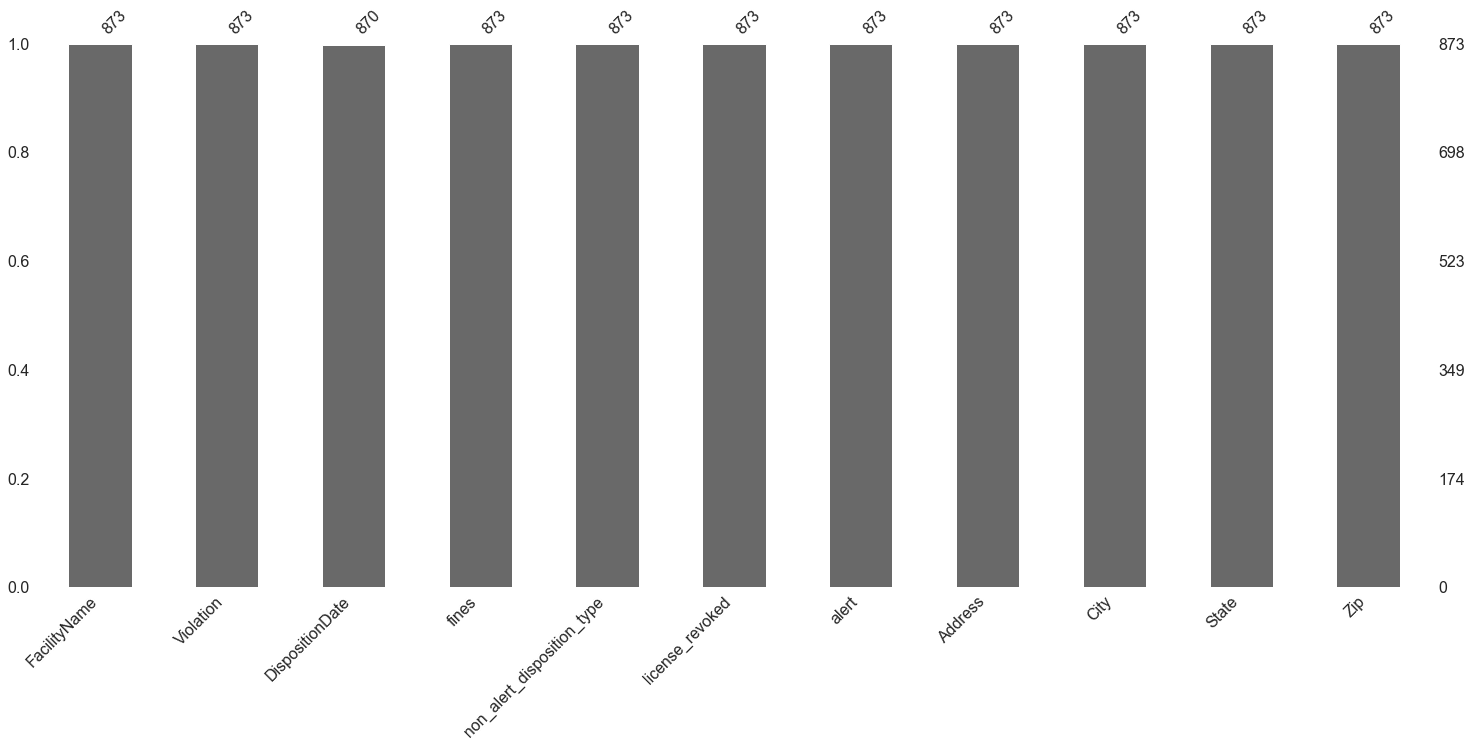

In [574]:
missingno.bar(df)
plt.show()

There are three DispositionDate values missing. Given the low number, we can impute these values with the mode value.

In [575]:
df['DispositionDate'] = df['DispositionDate'].fillna(value=df['DispositionDate'].mode().values[0])

We can then check to make sure nan imputation worked.

In [577]:
df.head()

,FacilityName,Violation,DispositionDate,fines,non_alert_disposition_type,license_revoked,alert,Address,City,State,Zip
0,FLOWER CHILD,Sale To Minor,03/05/2019,1000.0,setttled,0,1,10072 DARNESTOWN RD.,ROCKVILLE,MD,20860
1,BUFFALO WILD WINGS,Alcohol Awareness Certified Person Not On Prem...,08/21/2019,100.0,setttled,0,1,33 MARYLAND AVE.,ROCKVILLE,MD,20850
2,"TACOS, TORTAS & TEQUILA",License Not Properly Displayed,04/03/2019,100.0,setttled,0,1,8407 RAMSEY AVE.,SILVER SPRING,MD,20910
3,THE SPOT,Employee Records Not Available When Requested,08/06/2019,500.0,setttled,0,1,255 NORTH WASHINGTON ST.,ROCKVILLE,MD,20850
4,THE SPOT,Alcohol Awareness Certified Person Not On Prem...,08/06/2019,100.0,setttled,0,1,255 NORTH WASHINGTON ST.,ROCKVILLE,MD,20850


# Conclusion
We now have a dataframe for ABS license violations in Montgomery County that consists of useful cattegorical and continuous features.

In [578]:
df.to_csv('clean_abs_violations.csv')